In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
    dataset=tf.data.Dataset.from_tensor_slices(series)\
            .window(window_size+1,shift=1,drop_remainder=True)\
            .flat_map(lambda window:window.batch(window_size+1))\
            .shuffle(shuffle_buffer).map(lambda window:[window[:-1],window[-1]])\
            .batch(batch_size).prefetch(1)
    
    return dataset

In [8]:
dataset=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

l0=tf.keras.layers.Dense(1,input_shape=[window_size])

model=tf.keras.models.Sequential(l0)

model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-6,momentum=0.9),
              loss='mse')

model.fit(dataset,epochs=100,verbose=0)

Cause: could not parse the source code:

            .flat_map(lambda window:window.batch(window_size+1))\
            .shuffle(shuffle_buffer).map(lambda window:[window[:-1],window[-1]])\
            .batch(batch_size).prefetch(1)

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

            .flat_map(lambda window:window.batch(window_size+1))\
            .shuffle(shuffle_buffer).map(lambda window:[window[:-1],window[-1]])\
            .batch(batch_size).prefetch(1)

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

            .shuffle(shuffle_buffer).map(lambda window:[window[:-1],window[-1]])\
            .batch(batch_size).prefetch(1)

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

            .shuffle(shuffle_buffer).map(lambda window:[window[:-1],window[-1]])\
            .

In [10]:
print("Layer weights \n{}".format(l0.get_weights()))

Layer weights 
[array([[-0.12398759],
       [ 0.06351276],
       [ 0.06805065],
       [ 0.01966994],
       [-0.0450746 ],
       [ 0.01774645],
       [ 0.01329331],
       [ 0.04766294],
       [-0.0731044 ],
       [-0.00893239],
       [-0.01081108],
       [ 0.04579142],
       [-0.04370934],
       [ 0.05450996],
       [-0.02005557],
       [ 0.11368719],
       [ 0.06311404],
       [ 0.07000143],
       [ 0.25697634],
       [ 0.49356905]], dtype=float32), array([0.01473277], dtype=float32)]


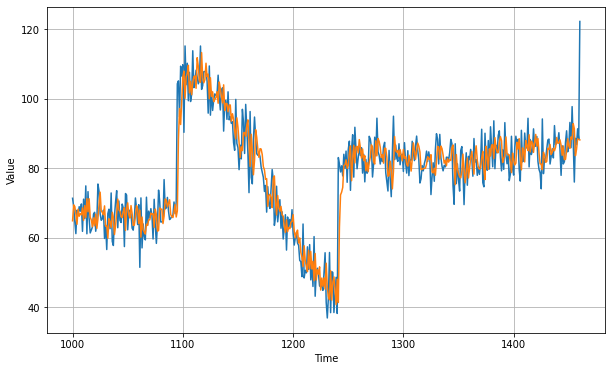

In [11]:
forecast=[]

for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
    
forecast=forecast[split_time-window_size:]
res=np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)
plot_series(time_valid,res)

In [12]:
print(tf.keras.metrics.mean_absolute_error(x_valid,res).numpy())

5.1569815
